# TA2 - CNNs on FashionMNIST (Benchmark Version)

This is the minimal benchmark run:
- simple CNN architecture
- Optuna tuning
- direct training/evaluation
- no persistence logic during training (that is, if our run gets cancelled halfway, we have to start over from scratch)

In [1]:
import os
import time
import random
from pathlib import Path
from typing import Any

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report

import optuna

from plot_utils import plot_random_raw_samples, plot_one_per_class

In [2]:
# Set the random seed for reproducibility
# np.random.seed() has a range of [0, 2**32 - 1] for the seed value
# print(np.random.randint(0, 2**32 - 1))  # Uncomment here for the first run to be a statistical purist
SEED = 1129775555  # Obviously your print is going to be something different


In [3]:
if torch.backends.mps.is_built() and torch.backends.mps.is_available():
    DEVICE = torch.device('mps')
elif torch.cuda.is_available():
    DEVICE = torch.device('cuda')
else:
    DEVICE = torch.device('cpu')

print(f'Using device: {DEVICE}')


Using device: mps


Is everyone clear on relative vs absolute paths? If not, do ask!

A short guide if you are using Jupyter notebooks would be to always use relative paths (that is, relative to the location of the notebook).

You only need to worry about absolute paths if you are doing more fancy settings like having a separate `src` folder for things like your model definition in a separate .py file for itself, and then you import that into your main.py file (or notebook). In that case, you do need to start worrying about absolute paths, because you can't always import functions or classes from a .py file using relative paths.

In [ ]:
DATA_ROOT = Path('../data')  # FashionMNIST will be stored in ../data/FashionMNIST
CLASS_NAMES = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
NUM_CLASSES = len(CLASS_NAMES)
VAL_RATIO = 0.10

MAX_EPOCHS = 15
FINAL_MAX_EPOCHS = 20
EARLY_STOPPING_PATIENCE = 4
N_TRIALS = 10
OPTUNA_TIMEOUT = None

NUM_WORKERS = min(4, os.cpu_count() or 1)
PIN_MEMORY = (DEVICE.type == 'cuda')
AMP_ENABLED = (DEVICE.type == 'cuda')

print(f'AMP enabled: {AMP_ENABLED}')

AMP enabled: False


In [5]:
def seed_everything(seed: int) -> None:
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    if torch.backends.cudnn.is_available():
        torch.backends.cudnn.benchmark = (DEVICE.type == 'cuda')

seed_everything(SEED)


## Data Loading and Raw Data Exploration

We inspect raw grayscale images and then build dataloaders with:
- augmentation on train only
- normalization on train/validation/test
- stratified split for class balance


In [6]:
raw_train = datasets.FashionMNIST(root=DATA_ROOT, train=True, download=True, transform=None)
raw_test = datasets.FashionMNIST(root=DATA_ROOT, train=False, download=True, transform=None)

print(f'Train size: {len(raw_train):,}')
print(f'Test size: {len(raw_test):,}')
print(f'Image shape: {raw_train[0][0].size} (grayscale)')
print(f'ACTUAL number of classes in the dataset: {len(raw_train.classes)}, vs declared number of classes: {NUM_CLASSES}')

Train size: 60,000
Test size: 10,000
Image shape: (28, 28) (grayscale)
ACTUAL number of classes in the dataset: 10, vs declared number of classes: 10


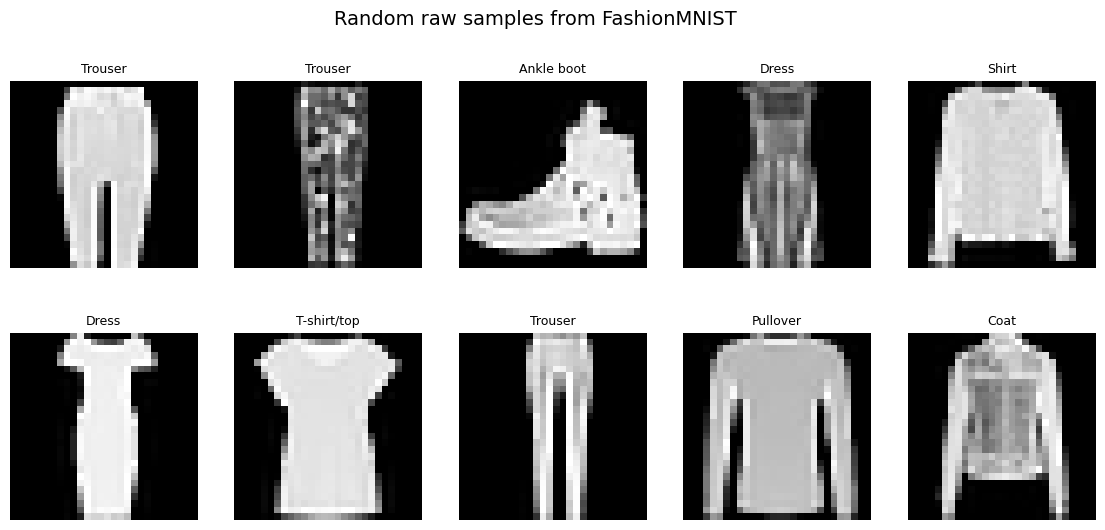

In [7]:
plot_random_raw_samples(raw_train, CLASS_NAMES, n=10, seed=SEED)

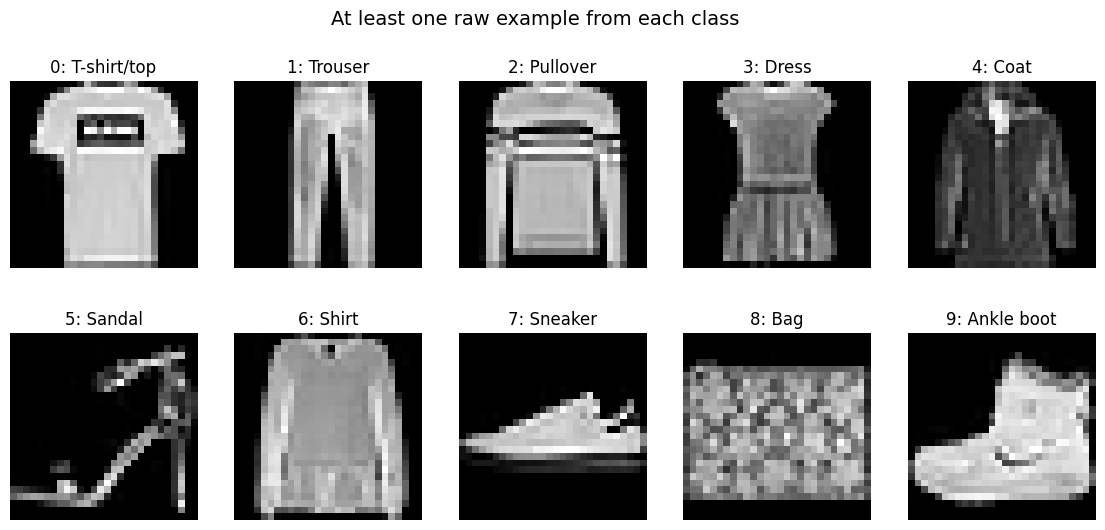

In [8]:
plot_one_per_class(raw_train, CLASS_NAMES)

In [ ]:
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomCrop(28, padding=2),
    transforms.ToTensor(),
    transforms.Normalize((0.2860,), (0.3530,)),
])

eval_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.2860,), (0.3530,)),
])

train_targets = np.array(raw_train.targets)
all_indices = np.arange(len(train_targets))
train_idx, val_idx = train_test_split(
    all_indices,
    test_size=VAL_RATIO,
    random_state=SEED,
    stratify=train_targets,
    shuffle=True,
)

train_dataset = datasets.FashionMNIST(root=DATA_ROOT, train=True, download=False, transform=train_transform)
val_dataset = datasets.FashionMNIST(root=DATA_ROOT, train=True, download=False, transform=eval_transform)
test_dataset = datasets.FashionMNIST(root=DATA_ROOT, train=False, download=False, transform=eval_transform)

train_subset = Subset(train_dataset, np.sort(train_idx))
val_subset = Subset(val_dataset, np.sort(val_idx))

print(f'Train subset size: {len(train_subset):,}')
print(f'Validation subset size: {len(val_subset):,}')
print(f'Test size: {len(test_dataset):,}')


def make_train_val_loaders(batch_size: int) -> tuple[DataLoader, DataLoader]:
    train_loader = DataLoader(
        train_subset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=NUM_WORKERS,
        pin_memory=PIN_MEMORY,
        persistent_workers=(NUM_WORKERS > 0),
    )
    val_loader = DataLoader(
        val_subset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=NUM_WORKERS,
        pin_memory=PIN_MEMORY,
        persistent_workers=(NUM_WORKERS > 0),
    )
    return train_loader, val_loader


def make_test_loader(batch_size: int) -> DataLoader:
    return DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=NUM_WORKERS,
        pin_memory=PIN_MEMORY,
        persistent_workers=(NUM_WORKERS > 0),
    )

example_loader, _ = make_train_val_loaders(batch_size=128)
x_example, y_example = next(iter(example_loader))
print('Batch X shape:', tuple(x_example.shape))
print('Batch y shape:', tuple(y_example.shape))


## Simple CNN Architecture

This is intentionally straightforward for teaching:
- 3 convolution blocks
- batch normalization + ReLU
- max pooling in first two blocks
- global average pooling + dropout + linear classifier


In [ ]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes: int = 10, dropout: float = 0.3):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
        )
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Dropout(p=dropout),
            nn.Linear(128, num_classes),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.features(x)
        x = self.classifier(x)
        return x


def count_trainable_parameters(model: nn.Module) -> int:
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

model_preview = SimpleCNN(num_classes=NUM_CLASSES, dropout=0.3).to(DEVICE)
print(f'Trainable parameters: {count_trainable_parameters(model_preview):,}')
del model_preview


In [ ]:
def compute_epoch_metrics(y_true: list[int], y_pred: list[int]) -> dict[str, float]:
    return {
        'accuracy': accuracy_score(y_true, y_pred),
        'macro_f1': f1_score(y_true, y_pred, average='macro'),
    }


def train_one_epoch(
    model: nn.Module,
    loader: DataLoader,
    optimizer: torch.optim.Optimizer,
    criterion: nn.Module,
    scaler: torch.amp.GradScaler,
) -> dict[str, float]:
    model.train()
    losses = []
    all_true, all_pred = [], []

    for x, y in loader:
        x = x.to(DEVICE, non_blocking=True)
        y = y.to(DEVICE, non_blocking=True)

        optimizer.zero_grad(set_to_none=True)

        if AMP_ENABLED:
            with torch.autocast(device_type='cuda', dtype=torch.float16):
                logits = model(x)
                loss = criterion(logits, y)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            logits = model(x)
            loss = criterion(logits, y)
            loss.backward()
            optimizer.step()

        losses.append(loss.item())
        all_true.extend(y.detach().cpu().tolist())
        all_pred.extend(torch.argmax(logits.detach(), dim=1).cpu().tolist())

    metrics = compute_epoch_metrics(all_true, all_pred)
    metrics['loss'] = float(np.mean(losses))
    return metrics


@torch.no_grad()
def evaluate_one_epoch(
    model: nn.Module,
    loader: DataLoader,
    criterion: nn.Module,
) -> tuple[dict[str, float], list[int], list[int]]:
    model.eval()
    losses = []
    all_true, all_pred = [], []

    for x, y in loader:
        x = x.to(DEVICE, non_blocking=True)
        y = y.to(DEVICE, non_blocking=True)

        if AMP_ENABLED:
            with torch.autocast(device_type='cuda', dtype=torch.float16):
                logits = model(x)
                loss = criterion(logits, y)
        else:
            logits = model(x)
            loss = criterion(logits, y)

        losses.append(loss.item())
        all_true.extend(y.detach().cpu().tolist())
        all_pred.extend(torch.argmax(logits.detach(), dim=1).cpu().tolist())

    metrics = compute_epoch_metrics(all_true, all_pred)
    metrics['loss'] = float(np.mean(losses))
    return metrics, all_true, all_pred


In [ ]:
def run_training(
    params: dict[str, Any],
    train_loader: DataLoader,
    val_loader: DataLoader,
    max_epochs: int,
    trial: optuna.trial.Trial | None = None,
) -> dict[str, Any]:
    model = SimpleCNN(num_classes=NUM_CLASSES, dropout=params['dropout']).to(DEVICE)
    criterion = nn.CrossEntropyLoss(label_smoothing=params['label_smoothing'])
    optimizer = torch.optim.AdamW(
        model.parameters(),
        lr=params['lr'],
        weight_decay=params['weight_decay'],
    )
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer,
        T_max=max_epochs,
        eta_min=1e-6,
    )
    scaler = torch.amp.GradScaler('cuda', enabled=AMP_ENABLED)

    best_val_macro_f1 = -1.0
    best_state_dict = None
    epochs_without_improvement = 0
    history_rows: list[dict[str, float]] = []

    for epoch in range(max_epochs):
        train_metrics = train_one_epoch(model, train_loader, optimizer, criterion, scaler)
        val_metrics, _, _ = evaluate_one_epoch(model, val_loader, criterion)
        scheduler.step()

        row = {
            'epoch': epoch,
            'train_loss': train_metrics['loss'],
            'train_accuracy': train_metrics['accuracy'],
            'train_macro_f1': train_metrics['macro_f1'],
            'val_loss': val_metrics['loss'],
            'val_accuracy': val_metrics['accuracy'],
            'val_macro_f1': val_metrics['macro_f1'],
            'lr': float(optimizer.param_groups[0]['lr']),
        }
        history_rows.append(row)

        val_score = val_metrics['macro_f1']
        if val_score > (best_val_macro_f1 + 1e-4):
            best_val_macro_f1 = val_score
            best_state_dict = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1

        if trial is not None:
            trial.report(val_score, step=epoch)
            if trial.should_prune():
                raise optuna.exceptions.TrialPruned(f'Pruned at epoch {epoch}')

        if epochs_without_improvement >= EARLY_STOPPING_PATIENCE:
            break

    if best_state_dict is not None:
        model.load_state_dict(best_state_dict)
        model = model.to(DEVICE)

    return {
        'model': model,
        'history_df': pd.DataFrame(history_rows),
        'best_val_macro_f1': float(best_val_macro_f1),
        'epochs_ran': int(len(history_rows)),
    }


## Hyperparameter Tuning with Optuna

We tune:
- learning rate
- weight decay
- dropout
- label smoothing
- batch size

Optimization target: **validation Macro-F1**.


In [ ]:
def suggest_params(trial: optuna.trial.Trial) -> dict[str, Any]:
    return {
        'lr': trial.suggest_float('lr', 1e-4, 5e-3, log=True),
        'weight_decay': trial.suggest_float('weight_decay', 1e-6, 5e-3, log=True),
        'dropout': trial.suggest_float('dropout', 0.10, 0.50),
        'label_smoothing': trial.suggest_float('label_smoothing', 0.0, 0.12),
        'batch_size': trial.suggest_categorical('batch_size', [64, 128, 256]),
    }


def objective(trial: optuna.trial.Trial) -> float:
    params = suggest_params(trial)
    train_loader, val_loader = make_train_val_loaders(batch_size=params['batch_size'])

    result = run_training(
        params=params,
        train_loader=train_loader,
        val_loader=val_loader,
        max_epochs=MAX_EPOCHS,
        trial=trial,
    )
    trial.set_user_attr('epochs_ran', result['epochs_ran'])
    return result['best_val_macro_f1']


In [ ]:
sampler = optuna.samplers.TPESampler(seed=SEED)
pruner = optuna.pruners.MedianPruner(n_startup_trials=5, n_warmup_steps=3)
study = optuna.create_study(
    study_name='ta2_cnns_benchmark',
    direction='maximize',
    sampler=sampler,
    pruner=pruner,
)

start_time = time.perf_counter()
study.optimize(objective, n_trials=N_TRIALS, timeout=OPTUNA_TIMEOUT, show_progress_bar=True)
search_minutes = (time.perf_counter() - start_time) / 60

print(f'Finished {len(study.trials)} trials in {search_minutes:.2f} minutes.')
print('Best validation Macro-F1:', round(study.best_value, 4))
print('Best params:', study.best_params)


In [ ]:
trials_df = study.trials_dataframe()
display(trials_df.sort_values('value', ascending=False).head(10))

plt.figure(figsize=(8, 4))
completed = trials_df[trials_df['state'] == 'COMPLETE']
plt.plot(completed['number'], completed['value'], marker='o')
plt.title('Validation Macro-F1 by completed trial')
plt.xlabel('Trial number')
plt.ylabel('Macro-F1')
plt.grid(True, alpha=0.3)
plt.show()


## Final Training and Out-of-Sample Evaluation

After tuning, we retrain with the best hyperparameters and evaluate on the held-out 10k test set.

Metrics:
- test loss
- test accuracy
- test Macro-F1
- per-class report
- confusion matrix


In [ ]:
best_params = study.best_trial.params.copy()
train_loader, val_loader = make_train_val_loaders(batch_size=best_params['batch_size'])

start_time = time.perf_counter()
final_result = run_training(
    params=best_params,
    train_loader=train_loader,
    val_loader=val_loader,
    max_epochs=FINAL_MAX_EPOCHS,
    trial=None,
)
final_minutes = (time.perf_counter() - start_time) / 60

best_model = final_result['model'].to(DEVICE)
print(f'Final training finished in {final_minutes:.2f} minutes')
print('Best validation Macro-F1:', round(final_result['best_val_macro_f1'], 4))
print('Epochs used:', final_result['epochs_ran'])


In [ ]:
criterion_eval = nn.CrossEntropyLoss()
test_loader = make_test_loader(batch_size=best_params['batch_size'])
test_metrics, y_true_test, y_pred_test = evaluate_one_epoch(best_model, test_loader, criterion_eval)

print('Test metrics (out-of-sample):')
print(f"  Loss:      {test_metrics['loss']:.4f}")
print(f"  Accuracy:  {test_metrics['accuracy']:.4f}")
print(f"  Macro-F1:  {test_metrics['macro_f1']:.4f}")

print('\nPer-class report:')
print(classification_report(y_true_test, y_pred_test, target_names=CLASS_NAMES, digits=4))


In [ ]:
cm = confusion_matrix(y_true_test, y_pred_test)

plt.figure(figsize=(10, 8))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=CLASS_NAMES,
    yticklabels=CLASS_NAMES,
)
plt.title('Test confusion matrix')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.tight_layout()
plt.show()
